#Polynomial Interpolation using Chebyshev Polynomials

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.html.widgets import interact
from IPython.html import widgets
from numpy.polynomial.chebyshev import Chebyshev
from scipy.misc import comb
from scipy import fftpack as ft

:0: FutureWarning: IPython widgets are experimental and may change in the future.


###Chebyshev Nodes

As noted before, Chebyshev nodes minimize the problem of Runge's phenomenom, which is where poylnomial interpolation is unstable at the edges of the interval.
Chebyshev nodes are the x-coordinates of equispaced points on the unit circle.
This places more points near the edges of the interval and can be found by:
$$
\cos\left[\frac{\pi}{n}(k+\frac{1}{2})\right] \text{ for }  k \in \mathbb{Z}, 0\leq k \lt n
$$

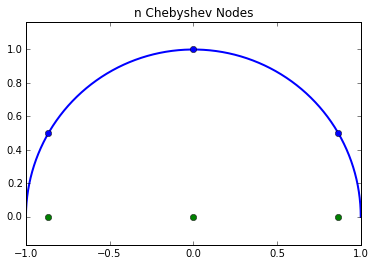

In [2]:
def plot_cheb(n):
    # plot the unit circle
    j = np.linspace(0,np.pi,1000)
    circ_x = np.cos(j)
    circ_y = np.sin(j)
    plt.plot(circ_x, circ_y, 'b', linewidth=2.0)
    
    # make n evenly spaced points on the circle
    i = np.arange(0,n)
    x = np.cos(np.pi/n*(i+.5))
    y = np.sin(np.pi/n*(i+.5))
    plt.plot(x, y, 'bo')
    
    # plot Chebyshev nodes
    plt.plot(x, np.zeros(n),'go')

    plt.axis('equal')
    plt.title("n Chebyshev Nodes")
    plt.show()
    
interact(plot_cheb, n=widgets.IntSliderWidget(min=3,max=30,step=1,value=10))

###Chebyshev Polynomials

The Chebyshev polynomials create a basis with which we can write any polynomial as a finite series.
They also can approximate resonably well-behaved functions on $[-1,1]$, and with some scaling, on any interval.

The $k^{th}$ Chebyshev polynomial is the real part of the function $z^k$ on the unit circle where $z(x) = x + i\sqrt{1-x^2}$. Then the $k^{th}$ Chebyshev polynomial is:
$$
T_k \left( x \right) = \frac{1}{2} \left( z^k + z^{-k} \right) = \cos \left( k \cos^{-1} \left( x \right) \right)
$$
The roots of the $k^{th}$ Chebyshev polynomial are the $k$ Chebyshev nodes.

Here are the $n$ basis polymials.

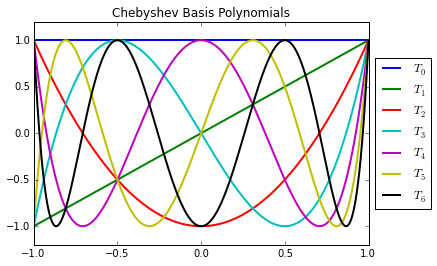

In [3]:
def cheb_polys(n, cheb_nodes):
    n = n+1
    resolution = 513
    X = np.linspace(-1, 1, resolution+1)
    for k in xrange(n):
        f = np.cos(k*np.arccos(X))
        plt.plot(X, f, label="$T_" + str(k) + "$", linewidth=2.0)
    plt.ylim((-1.2,1.2))
    
    plt.title("Chebyshev Basis Polynomials")
    
    if (cheb_nodes and n > 1):
        i = np.arange(0,n-1)
        x = np.cos(np.pi/(n-1)*(i+.5))
        plt.plot(x,np.zeros_like(x),'bo',label = "n Chebyshev Nodes")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
interact(cheb_polys, cheb_nodes=True, n=widgets.IntSliderWidget(min=0,max=6,step=1,value=0))

These basis polynomials are orthogonal with respect to the integral inner product 
$$
\langle f, g \rangle = \int_{-1}^1 \frac{1}{\sqrt{1 - x^2}} f\left( x \right) g\left( x \right) dx
$$

And thus we can write any polynomial as 
$$
p\left(x\right) = \sum_{k=0}^{n} a_k T_k\left(x\right)
$$

where $a_k$ can be found using the Discrete Fourier Transform:
$$
a_k = \frac{2}{\gamma k} \Re(DFT(p(x_0),p(x_1),...,p(x_{2n-1})))
$$

The strength of Chebyshev polynomials is that they converge quickly.
This lets us estimate a function with a much lower order polynomial.
The code below compares Chebyshev polynomials to Bernstein polynomials--another set of basis polynomials--when interpolating the function $f(x) = x^2 \sin(\pi(2x+1))$.
Notice how the Chebyshev polynomials converge to the function much faster.

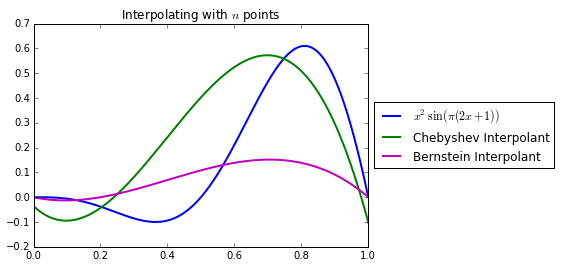

In [4]:
def nodes(a, b, n):
    """Get Chebyshev nodes on [a,b]"""
    vals = np.linspace(0, np.pi, n+1)
    np.cos(vals, out=vals)
    vals *= (b - a) / 2.
    vals += (b + a) / 2.
    # reverse order to get them in ascending order.
    return vals[::-1]
def get_coefs(samples):
    """Compute coefficients of the Chebyshev interpolant
    using the discrete cosine transform."""
    cfs = ft.dct(samples)
    cfs /= (samples.size - 1)
    cfs[::cfs.size-1] /= 2
    cfs[1::2] *= -1
    return cfs
def bpoly_interpolate(f,n,res):
    """Interpolate the function f using Bernstein Poylnomials.
    Assumes the domain is (0,1)."""
    x = np.linspace(0,1,res)
    y = np.zeros(res)
    for k in xrange(n):
        y += f(k*1./n)*comb(n,k)*x**k*(1-x)**(n-k)
    return y
def compare(n):
    """Interpolates the function f(x) = x^2*2sin(pi(2x+1)) using
    Bernstein Polynomials and Chebyshev Polynomials. Plots them to compare.
    """
    # The function to interpolate
    F = lambda x:x**2*np.sin(np.pi*(2*x+1))
    a = 0
    b = 1
    resolution = 100001
    X2 = np.linspace(a, b, resolution)
    # plot the function
    plt.plot(X2, F(X2), 'b', label = "$x^2 \\sin(\pi(2x+1))$", linewidth=2.0)
    
    # Chebyshev Interpolation
    X = nodes(a, b, n)
    cfs = get_coefs(F(X))
    f = Chebyshev(cfs,domain = [a,b])
    
    # Plot Chebyshev Interpolation
    plt.plot(X2, f(X2), 'g', label = "Chebyshev Interpolant", linewidth=2.0)
    
    # Bernstein Polynomial Interpolation
    bp = bpoly_interpolate(F,n,resolution)
    
    # Plot Bernstein Polynomial Interpolation
    plt.plot(X2, bp, 'm',label="Bernstein Interpolant", linewidth=2.0)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title("Interpolating with $n$ points")
    plt.show()
interact(compare, n=widgets.IntSliderWidget(min=3,max=60,step=3,value=3))